# Transformações e testes para séries temporais

  - Variância e transformação logarítmica
  - Tendência e ajuste de curvas
  - Sazonalidade e diferenciação aditiva e multiplicativa
  - Estacionariedade
    - Teste Augmented Dickey-Fuller (ADF)
    - Teste Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
  - Ruído branco
    - Teste Ljung-Box 
  - Normalidade
    - Teste Shapiro Wilk 
    - QQplot
    - Histograma
    - Teste Kolmogorov-Smirnov
    - Estratégias de normalização
  - Gráfico da função de auto correlação
  - Modelo auto-regressivo (AR)
  - Gráfico da função de auto correlação parcial
  - Modelo de média móvel (MA)
  - Modelo auto-regressivo de média móvel (ARMA)
  - Modelo auto-regressivo de média móvel com diferenciação (ARIMA)
  - Modelo SARIMAX
  - Métricas
    - SMAPE
    - MAPE
    - EVS
  - Estudo de caso Godaddy
  - Transformações inversas

In [9]:
# Datasets
from sktime.datasets import load_airline

# Data structure
import pandas as pd
import numpy as np

# EDA
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot

# transformations
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.boxcox import BoxCoxTransformer

## train test split
from sktime.forecasting.model_selection import temporal_train_test_split

## reduction with shifts
from sktime.forecasting.compose import make_reduction

# tests
import statsmodels.tsa.stattools as sm
from statsmodels.tsa.stattools import kpss # estacionariedade
import statsmodels.stats.diagnostic as diag # estacionariedade
from statsmodels.tsa.stattools import adfuller # estacionariedade
from scipy.stats import shapiro # normalidade
import pmdarima # sazonalidade
from statsmodels.api import qqplot # normalidade
from scipy.stats import kstest # normalidade

# forecast horizon
from sktime.forecasting.base import ForecastingHorizon

# pipeline
from sklearn.pipeline import Pipeline

# models
from statsmodels.tsa.arima.model import ARIMA
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor
from sktime.forecasting.trend import PolynomialTrendForecaster

# metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

# ajuste de curvas
from scipy import optimize

Uma série temporal com média constante e variância zero é considerada estacionária.

Modelos de regressão para séries temporais podem se ajustar com alta performance à séries temporais, mesmo estas não sendo estacionárias. Já modelos estatísticos, podem sofrer subajuste.

## Dataset

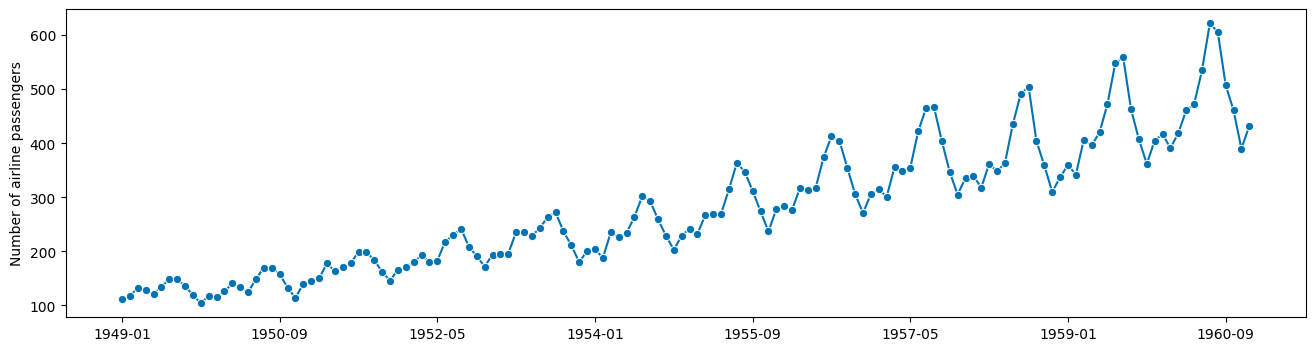

In [5]:
y = load_airline()
plot_series(y)
plt.show()

## Variância

A variância da série cresce a medida que a série cresce, uma transformação ideal para tratar tal série é a função log.

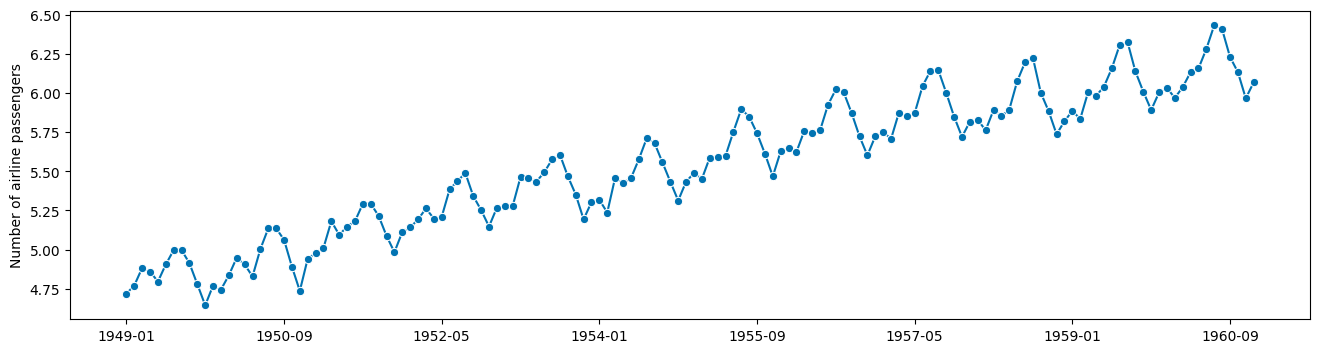

In [6]:
y = load_airline()
transformer = LogTransformer()
y = transformer.fit_transform(y)
plot_series(y)
plt.show()

## Tendência

Tendência pode ser identificada numa série se os valores da mesma, em geral, estão decrescendo ou crescendo. Observe na série como os valores estão aumentando ao longo do tempo.

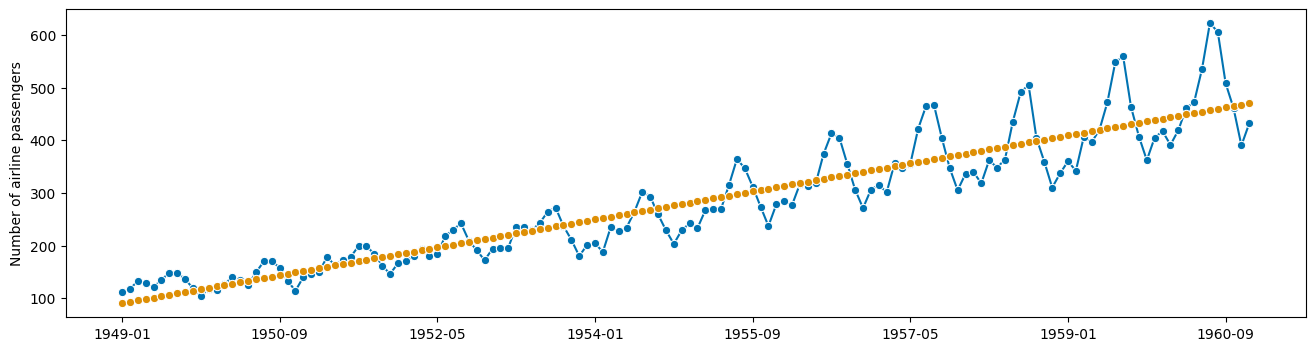

In [7]:
y = load_airline()
forecaster = PolynomialTrendForecaster(degree=1)
forecaster.fit(y)
y_pred = forecaster.predict(fh=y.index)

plot_series(y, y_pred)
plt.show()

- https://leandrocruvinel.medium.com/prevendo-o-n%C3%BAmero-de-casos-de-covid-19-em-uberaba-usando-python-d944adb594b4

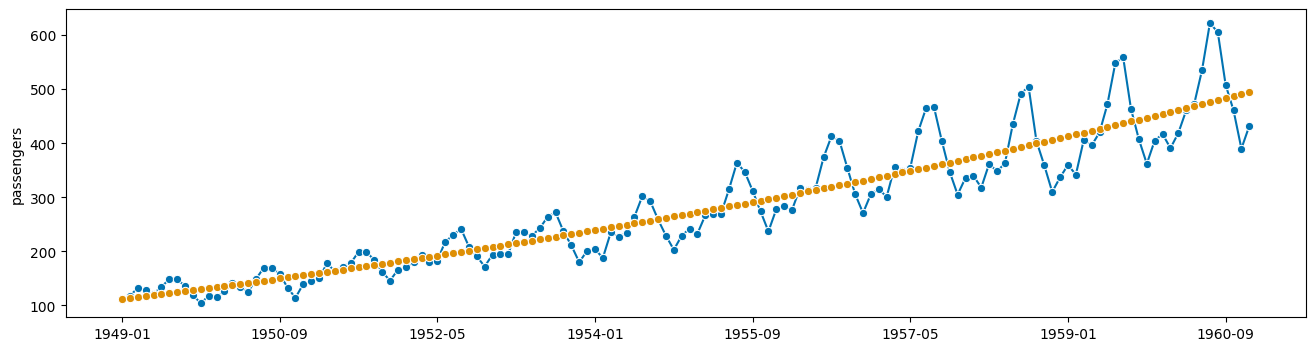

In [18]:
y = load_airline()

df = pd.DataFrame()
df['passengers'] = y
df.index = y.index

# funcão exponecial com parâmetros a, b e c
def exp_func(X, a, b, c):
    y = a + b**(X-c)
    return y

# otimização usando scipy
popt, pcov = optimize.curve_fit(exp_func, np.arange(len(df["passengers"])), df["passengers"].values)
df['curve'] = exp_func(np.arange(len(df["passengers"])), *popt)

plot_series(df['passengers'], df['curve'])
plt.show()

Alguns modelos não se ajustam bem em séries com tendências. Podemos remover a tendência com alguns métodos.

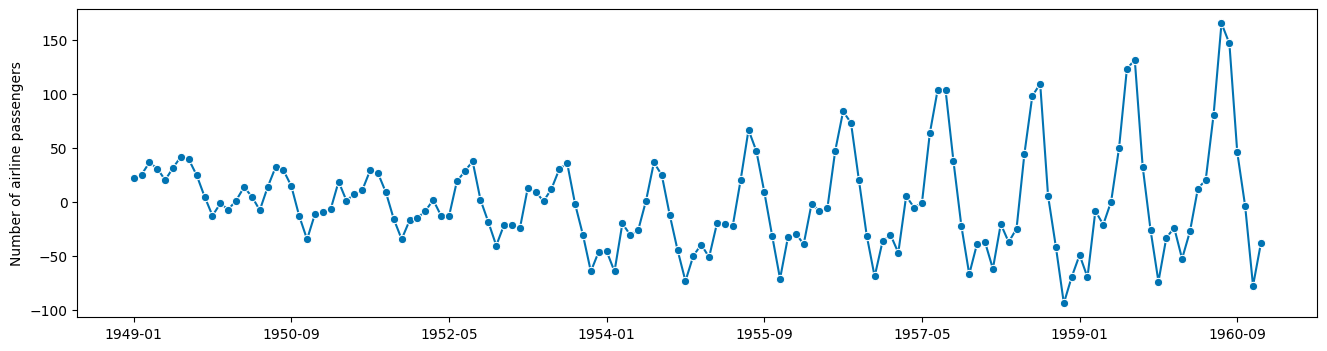

In [19]:
transformer = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
y = transformer.fit_transform(y)
plot_series(y)
plt.show()

## Sazonalidade

São padrões que se repetem em intervalos regulares de tempo. Observe que a série acima tem altas em meados de julho/agosto e baixas em janeiro. Este é outro padrão que pode afetar alguns modelos.

Podemos também remover a sazonalidade.

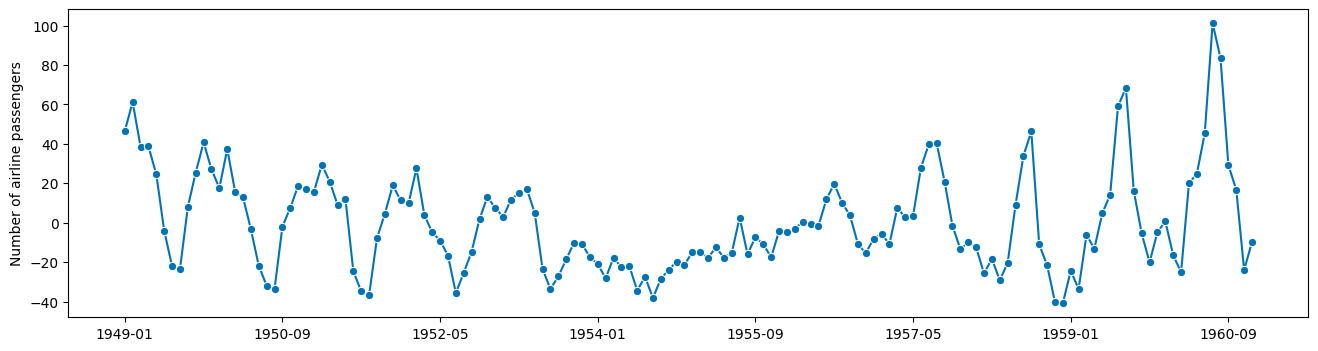

In [20]:
transformer = Deseasonalizer(sp=12, model='additive') # 12 meses
y = transformer.fit_transform(y)
plot_series(y)
plt.show()

## Visualizando tendência e sazonalidade

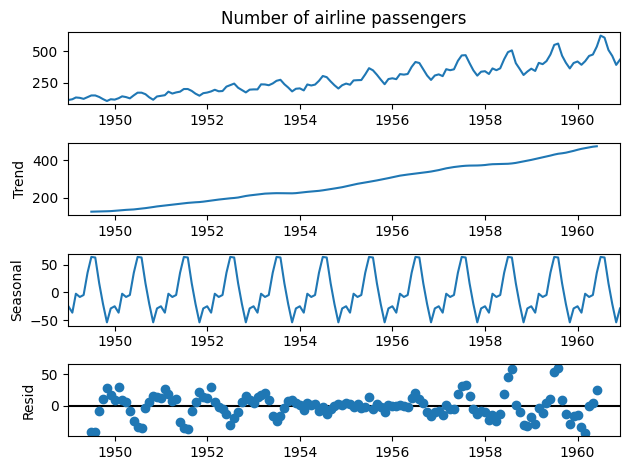

In [21]:
y = load_airline()
y.interpolate(inplace = True)
y.index = y.index.to_timestamp()
decomposition = seasonal_decompose(y, model="additive")
decomposition.plot()
plt.show()

$$Y_t = T_t + S_t + R_t$$

## Estacionariedade

Podemos fazer um testes estatístico para verificar a estacionariedade da série.

In [22]:
non_st_test = adfuller(y)
output = pd.Series(
    non_st_test[0:4], 
    index=[
        't-statistic',
        'p-value',
        'lags-used',
        'no-of-observations'
    ])
for key,value in non_st_test[4].items():
    output['Critical Value (%s)' % key] = value

print("Null hypotesis: there is a unit root.")
print("Alternative hypotesis: there is no unit root.")    

print("Results of Augmented Dickey-Fuller (ADF) test:")
output

Null hypotesis: there is a unit root.
Alternative hypotesis: there is no unit root.
Results of Augmented Dickey-Fuller (ADF) test:


t-statistic               0.815369
p-value                   0.991880
lags-used                13.000000
no-of-observations      130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64

p-value > 0.05, a série é estacionária.

In [23]:
adf_test = pmdarima.arima.ADFTest(alpha=0.05, k=None)
adf_test.should_diff(y) # precisa de diferenciação?

(0.01, False)

Podemos fazer outro teste para validar nossas conclusões.

In [24]:
print("Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")

print("Null Hypothesis: The process is trend stationary.")
print("Alternate Hypothesis: The series has a unit root (series is not stationary).")

non_st_test = sm.kpss(y)
output = pd.Series(
    non_st_test[0:3], 
    index=['KPSS Statistic','p-value','#Lags Used'])

for key,value in non_st_test[3].items():
    output['Critical Value (%s)'%key] = value
    
print(output)

Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
Null Hypothesis: The process is trend stationary.
Alternate Hypothesis: The series has a unit root (series is not stationary).
KPSS Statistic           1.651312
p-value                  0.010000
#Lags Used               8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\leandro\Downloads\cd2023\cd2023\env\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


p-value > 0.05, aceito a hipótese nula e, portanto, assumo que a série é estacionária.

### Ruído branco

Se a série for um ruído branco ela não pode ser modelada. Faremos um teste para verificar se a série é um ruído branco:

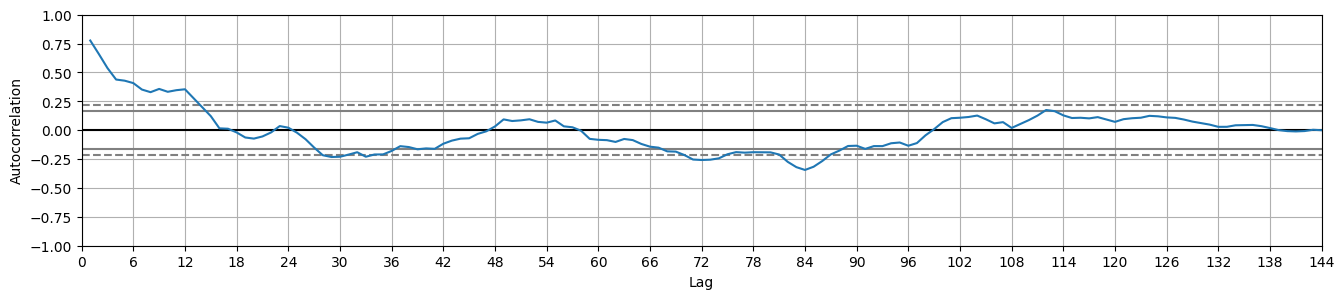

In [25]:
# dados
y = load_airline()

# transformers
transformer1 = LogTransformer()
transformer2 = Detrender()
transformer3 = Deseasonalizer(sp=12)

y = transformer1.fit_transform(y)
y = transformer2.fit_transform(y)
y = transformer3.fit_transform(y)

plt.figure(figsize=(16,3))
pd.plotting.autocorrelation_plot(y)
plt.xticks(list(range(0,145,6)))
plt.show()

Observe que há uma correlação significante no lag 12 o que indica que a série possui correlação com ela mesmo. Logo não se trata de um ruído branco.

Outra forma de fazer o mesmo gráfico.

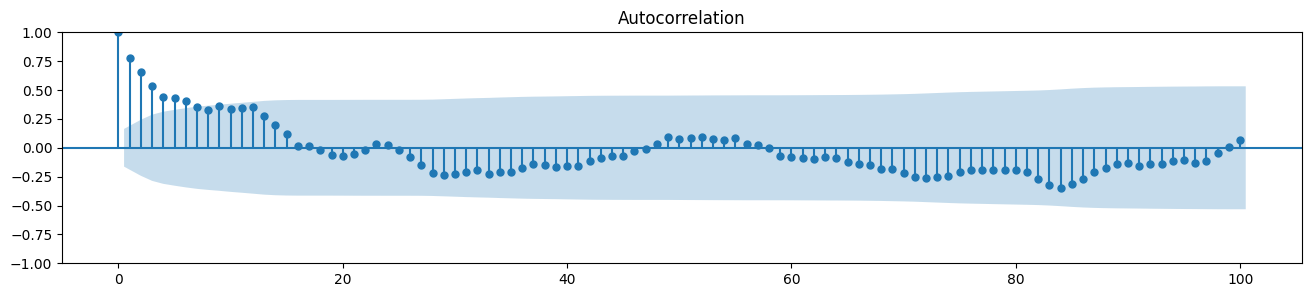

In [26]:
f = plt.figure(figsize=(16,3))
ax = f.subplots()
plot_acf(y, lags=100, ax=ax)
plt.show()

Observe que o gráfico de autocorrelação apresenta um valor acima de 0.5 no lag 2. Podemos fazer um teste estatístico para verificar tal correlação.

In [27]:
print("Null Hypothesis: The series has no autocorrelation.")
print("Alternate Hypothesis: The series has autocorrelation.")
 
diag.acorr_ljungbox(
    y,
    lags=list(range(2,13)),
    return_df=True
)

Null Hypothesis: The series has no autocorrelation.
Alternate Hypothesis: The series has autocorrelation.


,lb_stat,lb_pvalue
2,153.053859,5.818041e-34
3,196.192862,2.803754e-42
4,225.108002,1.491492e-47
5,252.922032,1.297533e-52
6,278.281532,3.664833e-57
7,297.303328,2.278068e-60
8,314.081741,4.132624e-63
9,333.994399,1.574050e-66
10,351.360653,2.049411e-69
11,370.356764,1.185700e-72


Como p-value é abaixo de 0.05 rejeitamos a hipótese nula e assumimos a alternativa. Portanto a série tem auto correlação e não é um ruído branco.

## Normalidade

De maneira geral, séries temporais normais também se ajustam melhor a modelos menos robustos. 

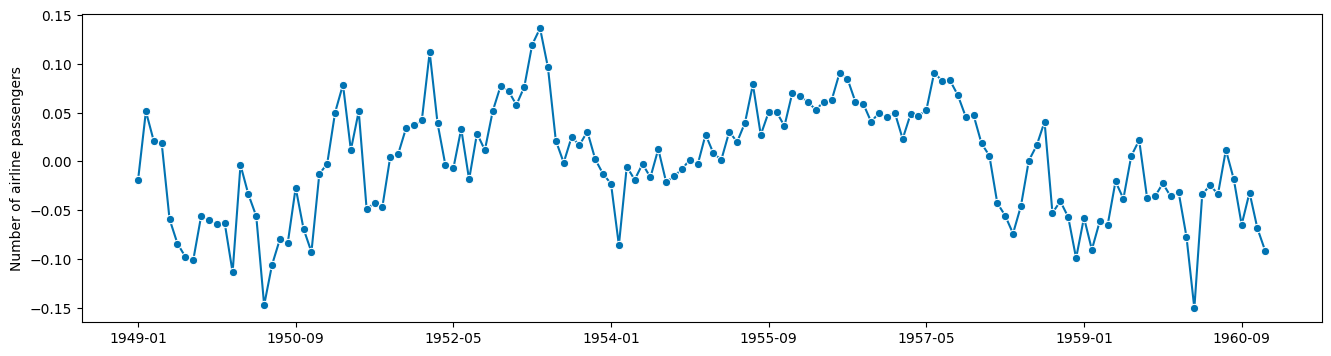

In [28]:
# dados
y = load_airline()

# transformers
transformer1 = LogTransformer()
transformer2 = Detrender()
transformer3 = Deseasonalizer(sp=12)

y = transformer1.fit_transform(y)
y = transformer2.fit_transform(y)
y = transformer3.fit_transform(y)

plot_series(y)
plt.show()

In [29]:
print("null hypothesis: it's a normal distribution")
shapiro(y)

null hypothesis: it's a normal distribution


ShapiroResult(statistic=0.9902021884918213, pvalue=0.4139399230480194)

p > 0.05, aceitamos a hipótese nula.

Vejamos o histograma:

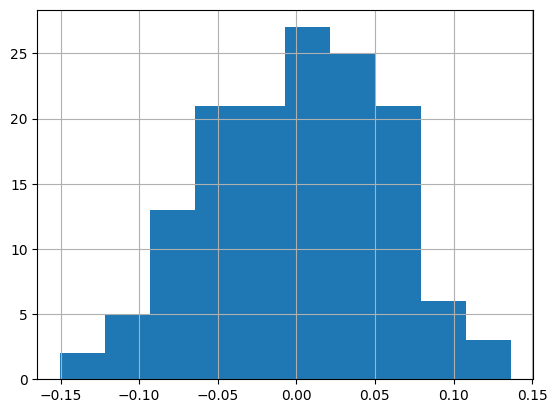

In [30]:
y.hist()
plt.show()

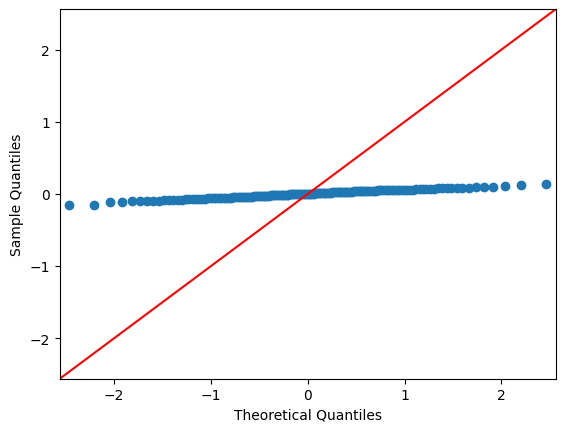

In [31]:
# quanto mais próximo na linha 
# mais próxima da normal
qqplot(y, line='45')
plt.show()

In [32]:
# Kolmogorov-Smirnov Test
kstest(y, 'norm')

KstestResult(statistic=0.4457339631938868, pvalue=1.3317288710746455e-26)

p < 0.05, não vem de uma normal.

In [33]:
y = (y - y.mean()) / y.std()

In [34]:
kstest(y, 'norm')

KstestResult(statistic=0.05229572454610254, pvalue=0.8061456718616435)

p > 0.05, vem de uma normal.

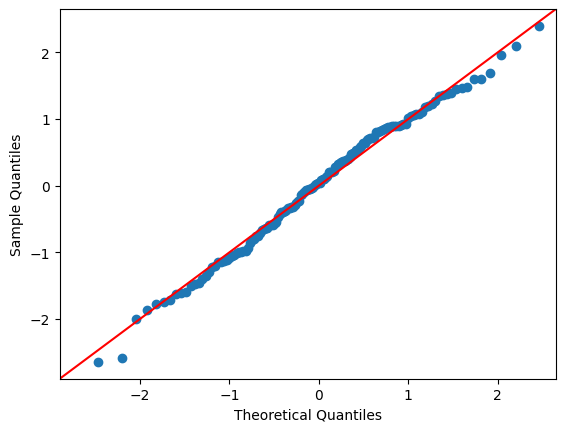

In [35]:
qqplot(y, line='45')
plt.show()

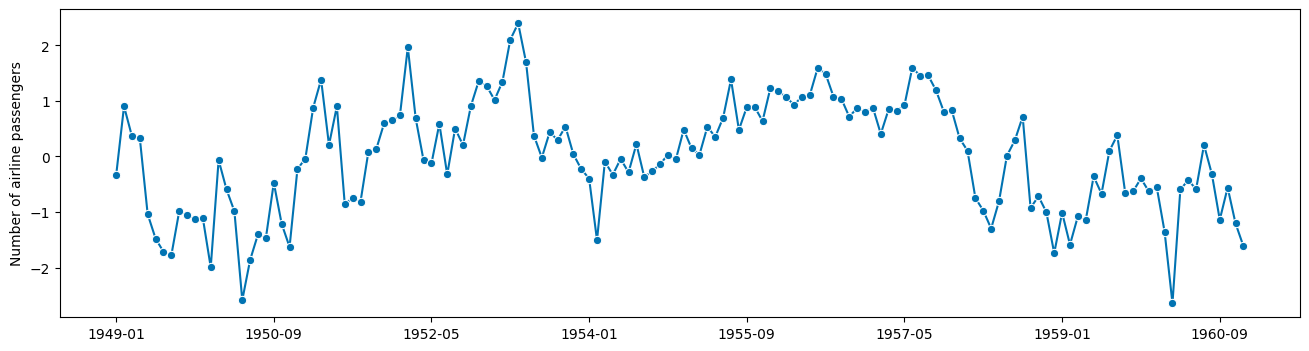

In [36]:
plot_series(y)
plt.show()

Podemos tentar transformar a série para que ela se aproxime de uma normal com Box-Cox.

In [38]:
# dados
y = load_airline()

transformer = BoxCoxTransformer()
y = transformer.fit_transform(y)

In [39]:
kstest(y, 'norm')

KstestResult(statistic=0.9999999999879958, pvalue=0.0)

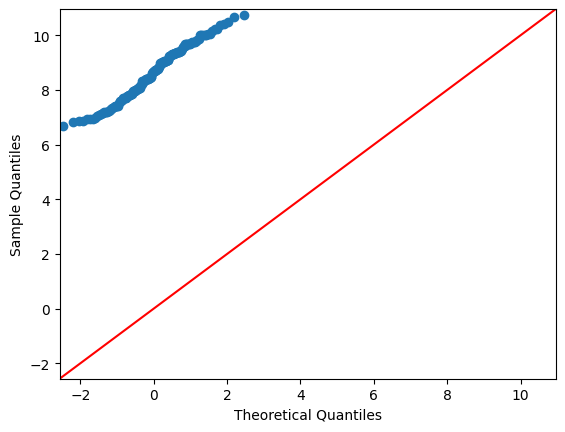

In [40]:
qqplot(y, line='45')
plt.show()

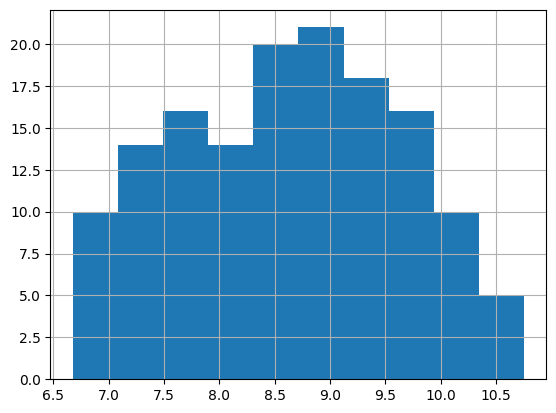

In [41]:
y.hist()
plt.show()

Box-Cox não deu ¯\_(ツ)_/¯

## Modelo auto regressivo (AR)

Vamos considerar a mesma série. Queremos prever os 24 últimos períodos.

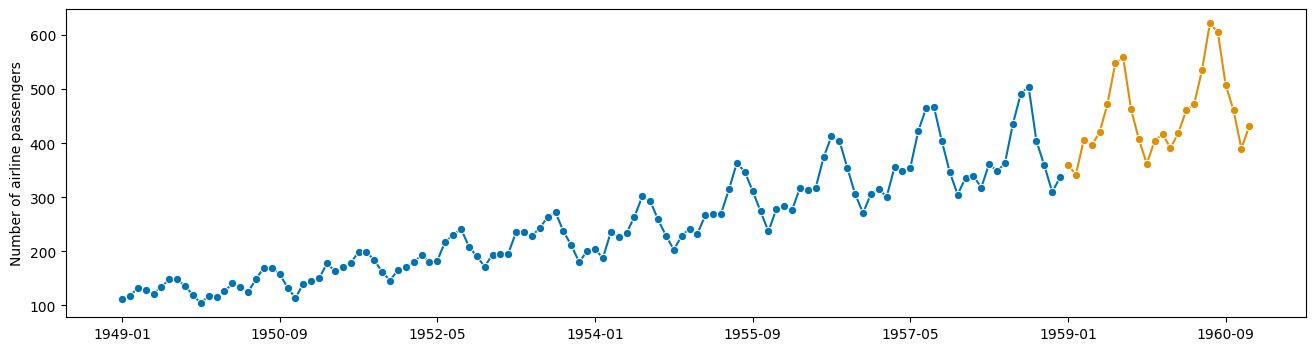

In [42]:
# tomemos n = 12
y = load_airline()

fh = np.arange(24)

y_train, y_test = temporal_train_test_split(y, test_size=24)
plot_series(y_train, y_test)
plt.show()

Um modelo AR(p) assume por hipótese que a observação no período t possui uma relação linear com os p períodos anteriores:

$$Y_t = \alpha_0 + \alpha_1 Y_{t-1} + \alpha_2 Y_{t-2} + \cdots + \alpha_p Y_{t-p}$$

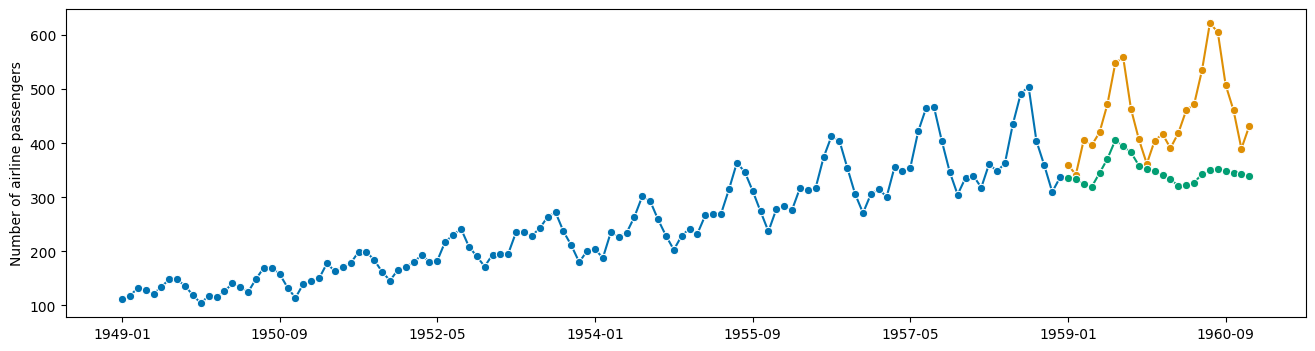

In [43]:
p = 12

model = ARIMA(y_train, order=(p,0,0))

model_fit = model.fit(method="yule_walker")

y_pred = model_fit.forecast(steps=24)

plot_series(y_train, y_test, y_pred)
plt.show()

In [44]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:     Number of airline passengers   No. Observations:                  120
Model:                          ARIMA(12, 0, 0)   Log Likelihood                -550.155
Date:                          Wed, 05 Jul 2023   AIC                           1128.311
Time:                                  08:25:45   BIC                           1167.336
Sample:                              01-31-1949   HQIC                          1144.159
                                   - 12-31-1958                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        246.1492     76.747      3.207      0.001      95.727     396.572
ar.L1          1.1065      0.306      3.615      0.000       0.507       1.706
ar.L2         -0.2957      0.402     -0.736      0.462      -1.083       0.491
ar.L3          0.0479      0.324      0.148      0.882      -0.587       0.682
ar.L4         -0.0338      0.295     -0.115      0.909      -0.612       0.545
ar.L5          0.0448      0.358      0.125      0.900      -0.657       0.747
ar.L6          0.0093      0.394      0.024      0.981      -0.763       0.781
ar.L7         -0.0259      0.359     -0.072      0.942      -0.729       0.677
ar.L8         -0.1179      0.411     -0.287      0.774      -0.923       0.688
ar.L9          0.1848      0.384      0.481      0.630      -0.568       0.937
ar.L10        -0.1791      0.343     -0.522      0.601      -0.851       0.493
ar.L11         0.3591      0.384      0.935      0.350      -0.393       1.111
ar.L12        -0.1267      0.312     -0.407      0.684      -0.737       0.484
sigma2       797.5234    180.881      4.409      0.000     443.002    1152.044
===================================================================================
Ljung-Box (L1) (Q):                   1.49   Jarque-Bera (JB):                 3.26
Prob(Q):                              0.22   Prob(JB):                         0.20
Heteroskedasticity (H):               5.14   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
explained_variance_score(y_pred, y_test)

-8.576350218565873

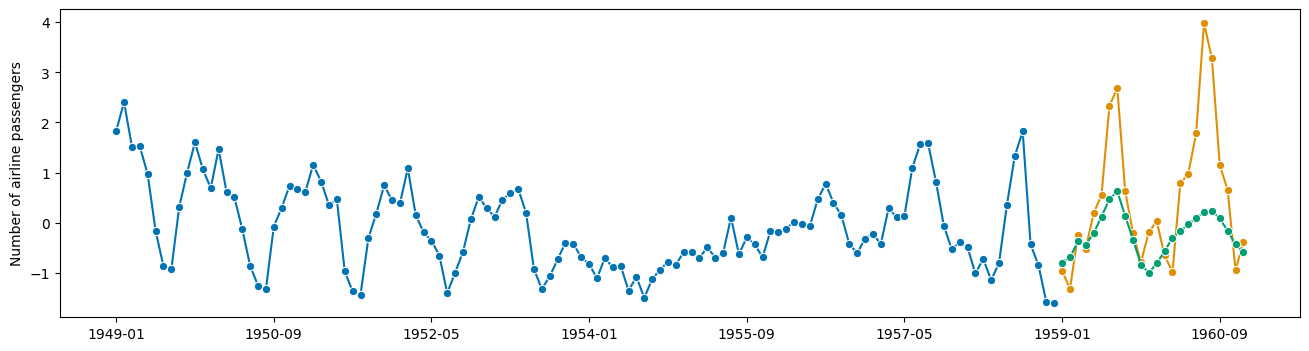

In [46]:
y = load_airline()

# transformers
transformer1 = Detrender()
transformer2 = Deseasonalizer(sp=12)

y = transformer1.fit_transform(y)
y = transformer2.fit_transform(y)
y = (y - y.mean())/y.std()

y_train, y_test = temporal_train_test_split(y, test_size=24)

p = 12
model = ARIMA(y_train, order=(p,0,0))
model_fit = model.fit(method="yule_walker")
y_pred = model_fit.forecast(steps=24)

plot_series(y_train, y_test, y_pred)
plt.show()

O modelo se ajustou melhor, logo a importância de remover tendência e sazonalidade.

In [47]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:     Number of airline passengers   No. Observations:                  120
Model:                          ARIMA(12, 0, 0)   Log Likelihood                 -72.021
Date:                          Wed, 05 Jul 2023   AIC                            172.042
Time:                                  08:25:48   BIC                            211.067
Sample:                              01-31-1949   HQIC                           187.890
                                   - 12-31-1958                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.308     -0.013      0.990      -0.607       0.599
ar.L1          0.8848      0.141      6.275      0.000       0.608       1.161
ar.L2         -0.2048      0.188     -1.091      0.275      -0.573       0.163
ar.L3         -0.0233      0.195     -0.120      0.905      -0.405       0.359
ar.L4         -0.2460      0.180     -1.368      0.171      -0.598       0.106
ar.L5          0.2735      0.185      1.478      0.139      -0.089       0.636
ar.L6         -0.1168      0.201     -0.581      0.561      -0.511       0.277
ar.L7          0.0859      0.197      0.436      0.663      -0.300       0.472
ar.L8         -0.1349      0.226     -0.596      0.551      -0.579       0.309
ar.L9          0.1365      0.206      0.662      0.508      -0.268       0.541
ar.L10        -0.0137      0.186     -0.074      0.941      -0.378       0.350
ar.L11         0.0963      0.189      0.511      0.610      -0.273       0.466
ar.L12         0.1306      0.148      0.884      0.377      -0.159       0.420
sigma2         0.2220      0.037      6.051      0.000       0.150       0.294
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 8.69
Prob(Q):                              0.83   Prob(JB):                         0.01
Heteroskedasticity (H):               0.88   Skew:                            -0.28
Prob(H) (two-sided):                  0.68   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

De maneira geral, quanto menores forem o Akaike Information Criterion (AIC) e o Bayesian Information Criteria (BIC), melhor o modelo.

In [48]:
explained_variance_score(y_pred, y_test)

-5.4491395474401

## Modelo de média móvel (MA)

Os modelos de média móvel MA(q) assumem como hipótese que a série no tempo t possui uma relação linear com os erros nos q tempos anteriores.

$$Y_t = \alpha_0 + \alpha_1 \epsilon_{t-1} + \alpha_2 \epsilon_{t-2} + \cdots + \alpha_p \epsilon_{t-p}$$

Para estimar q podemos usar o gráfico de auto correlação parcial.

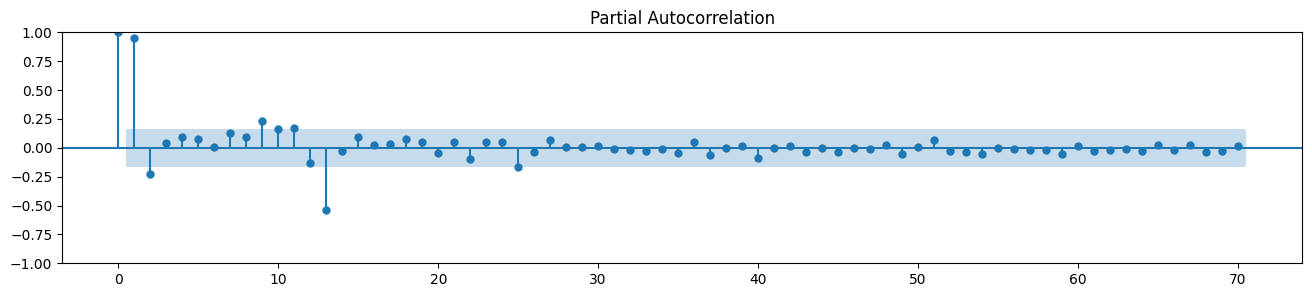

In [49]:
y = load_airline()


f = plt.figure(figsize=(16,3))
ax = f.subplots()
plot_pacf(y, lags=70, ax=ax, method='ywm')
plt.show()

C:\Users\leandro\Downloads\cd2023\cd2023\env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\leandro\Downloads\cd2023\cd2023\env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


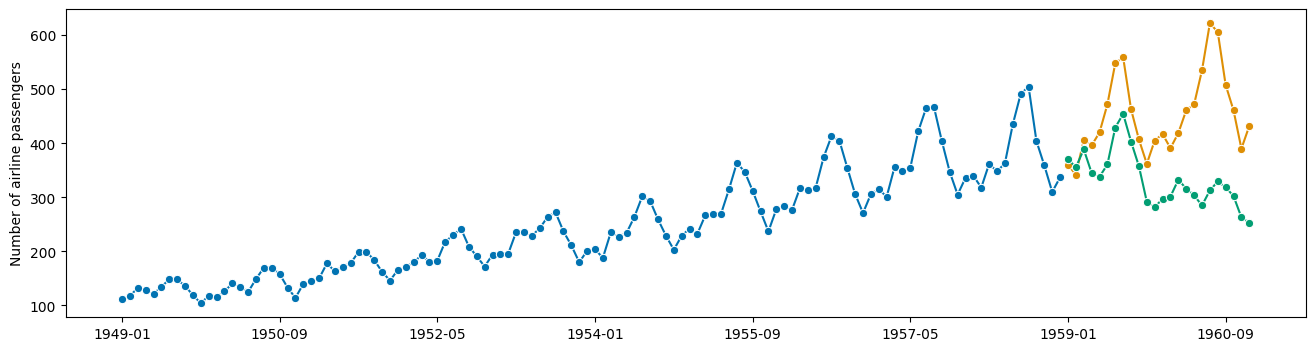

In [50]:
y_train, y_test = temporal_train_test_split(y, test_size=24)

q = 24

model = ARIMA(y_train, order=(0,0,q))

model_fit = model.fit()

y_pred = model_fit.forecast(steps=24)

plot_series(y_train, y_test, y_pred)
plt.show()

C:\Users\leandro\Downloads\cd2023\cd2023\env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\leandro\Downloads\cd2023\cd2023\env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


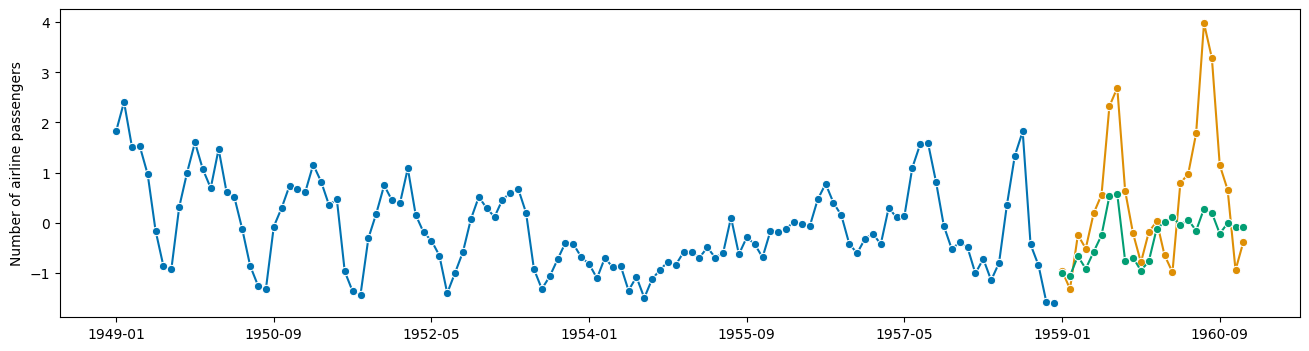

In [51]:
y = load_airline()

# transformers
transformer1 = Detrender()
transformer2 = Deseasonalizer(sp=12)

y = transformer1.fit_transform(y)
y = transformer2.fit_transform(y)
y = (y - y.mean())/y.std()

y_train, y_test = temporal_train_test_split(y, test_size=24)

q=24
model = ARIMA(y_train, order=(0,0,q))
model_fit = model.fit()
y_pred = model_fit.forecast(steps=24)

plot_series(y_train, y_test, y_pred)
plt.show()

In [52]:
explained_variance_score(y_pred, y_test)

-4.746728335180438

## Modelos autoregressivos de média móvel (ARMA)

C:\Users\leandro\Downloads\cd2023\cd2023\env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\leandro\Downloads\cd2023\cd2023\env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\leandro\Downloads\cd2023\cd2023\env\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


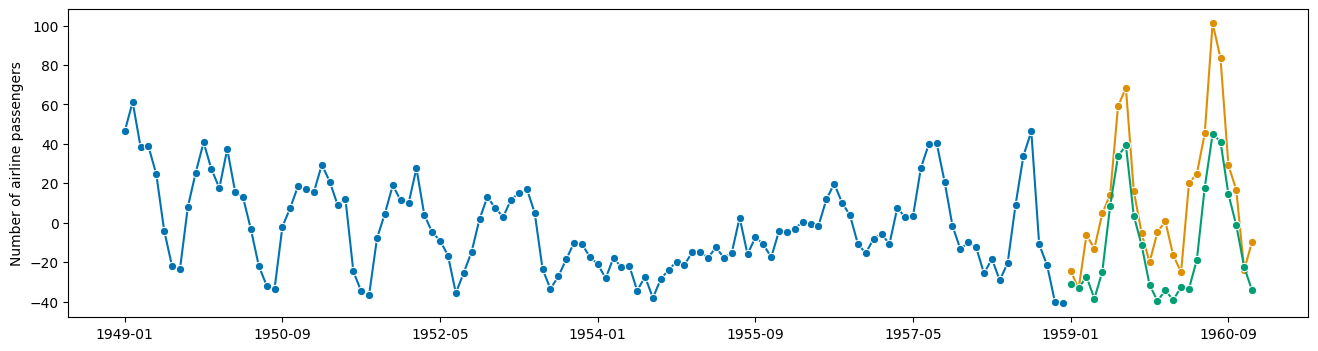

In [53]:
y = load_airline()

# transformers
transformer1 = Detrender()
transformer2 = Deseasonalizer(sp=12)

y = transformer1.fit_transform(y)
y = transformer2.fit_transform(y)

y_train, y_test = temporal_train_test_split(y, test_size=24)

model = ARIMA(y_train, order=(12,0,24))
model_fit = model.fit()
y_pred = model_fit.forecast(steps=24)

plot_series(y_train, y_test, y_pred)
plt.show()

In [54]:
explained_variance_score(y_pred, y_test)

0.6923950255555814

## Modelos autoregressivos de média móvel com diferenciação (ARIMA)

In [55]:
y = load_airline()

# transformers
transformer1 = Detrender()
transformer2 = Deseasonalizer(sp=12)

# y = np.log1p(y)
y = transformer1.fit_transform(y)
y = transformer2.fit_transform(y)
y = (y - y.mean())/y.std()

y_train, y_test = temporal_train_test_split(y, test_size=24)

forecaster = AutoARIMA( # SARIMAX
    sp=12, max_p=24, max_d=6, max_q=24, 
    maxiter=5000,
    suppress_warnings=True)  
forecaster.fit(y_train)  

y_pred = forecaster.predict(fh=y_test.index)  

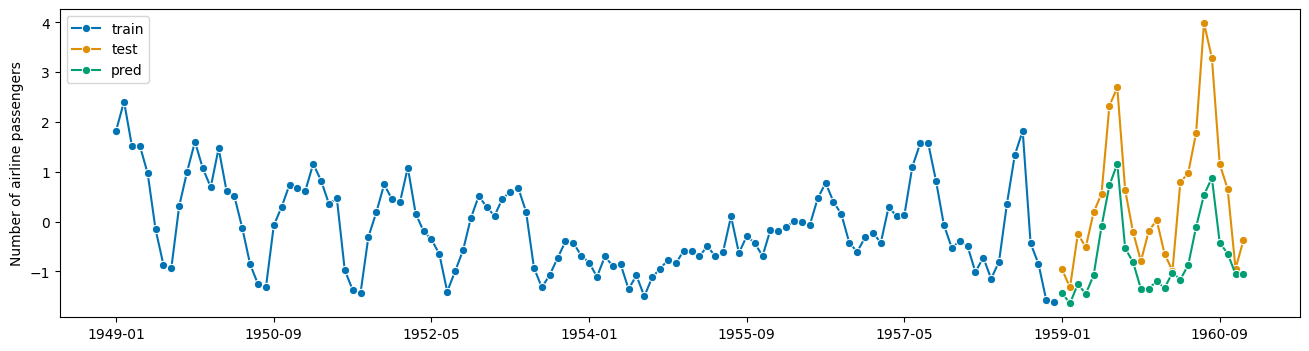

In [56]:
plot_series(y_train, y_test, y_pred, labels=['train','test','pred'])
plt.legend()
plt.show()

In [57]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 -59.605
Date:                            Wed, 05 Jul 2023   AIC                            125.210
Time:                                    08:26:09   BIC                            133.572
Sample:                                01-31-1949   HQIC                           128.606
                                     - 12-31-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8117      0.056     14.474      0.000       0.702       0.922
ar.S.L12       0.7710      0.068     11.319      0.000       0.638       0.905
sigma2         0.1430      0.016      8.922      0.000       0.112       0.174
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 8.13
Prob(Q):                              0.71   Prob(JB):                         0.02
Heteroskedasticity (H):               1.38   Skew:                            -0.37
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
explained_variance_score(y_pred, y_test)

0.06124085586152517

## Estudo de caso GoDaddy

In [59]:
train = pd.read_csv('../datasets/godaddy/train.csv')
test = pd.read_csv('../datasets/godaddy/test.csv')

In [60]:
train.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active'],
      dtype='object')

In [61]:
test.columns

Index(['row_id', 'cfips', 'first_day_of_month'], dtype='object')

In [62]:
# remove county and state
train = train.drop(['county','state'], axis=1)

In [63]:
# target: microbusiness_density
train.head(3)

,row_id,cfips,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,2019-10-01,3.055843,1269


In [64]:
# Parse datas
train['Date'] = pd.to_datetime(train['first_day_of_month'])
test['Date'] = pd.to_datetime(test['first_day_of_month'])
train['Date'] = train['Date'].dt.to_period('M')
test['Date'] = test['Date'].dt.to_period('M')
# Datas no índice
train.index = train.Date
test.index = test.Date
# sort index 
train.sort_index(inplace=True)

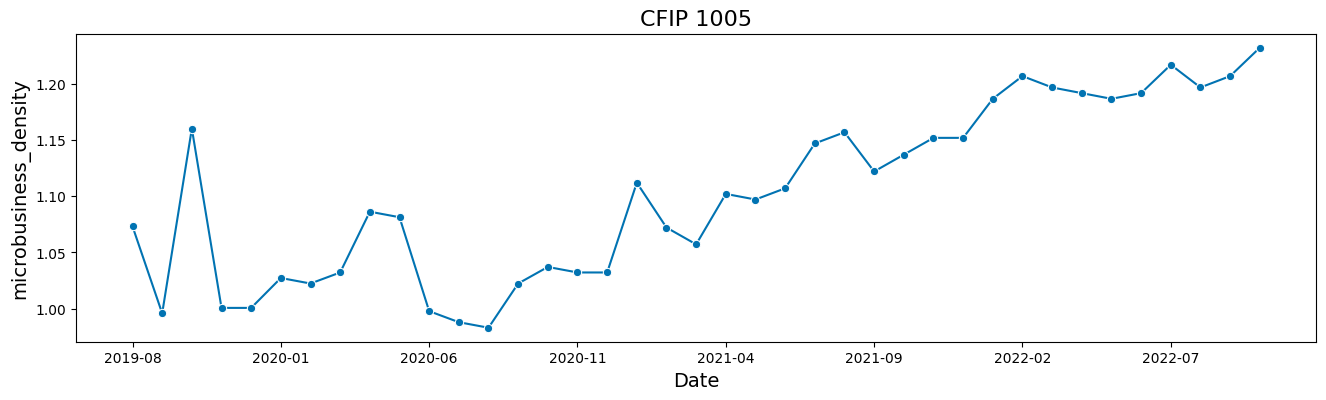

In [65]:
# EDA
data = train.loc[train.cfips == 1005]
plot_series(data['microbusiness_density'])
plt.title('CFIP 1005', size = 16)
plt.xlabel('Date', size = 14)
plt.ylabel('microbusiness_density', size=14)
plt.show()

In [66]:
# 3135 cfips únicos
len(train['cfips'].unique())

3135

In [67]:
def adfuller_test(data):
    result = adfuller(data)
    labels = ['ADS statistic', 'p', 'lags', 'no. of obs']
    
    for i, c in zip(result, labels):
        print(c+':'+str(i))
    if result[1] < 0.05:
        print("the data is stationary")
    else:
        print("the data is seasonal")

In [68]:
# is stationary?
adfuller_test(train.loc[train.cfips == 1001]['microbusiness_density'])

ADS statistic:0.9881707095895983
p:0.9941395544199386
lags:9
no. of obs:29
the data is seasonal


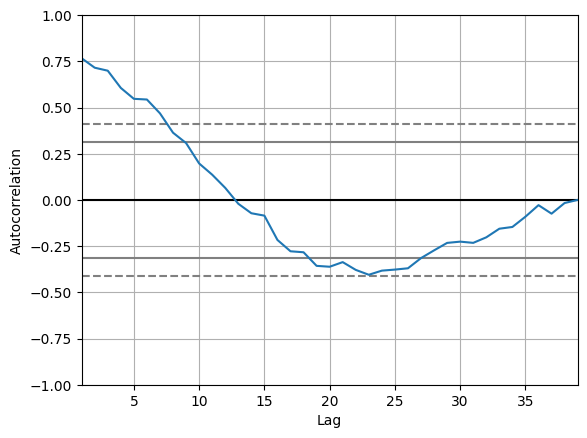

In [69]:
# autocorrelation (white noise and lags)
pd.plotting.autocorrelation_plot(train.loc[train.cfips == 1005]['microbusiness_density'])
plt.show()

In [70]:
train.loc[train.cfips == 1001]

,row_id,cfips,first_day_of_month,microbusiness_density,active,Date
Date,,,,,,
2019-08,1001_2019-08-01,1001,2019-08-01,3.007682,1249,2019-08
2019-09,1001_2019-09-01,1001,2019-09-01,2.884870,1198,2019-09
2019-10,1001_2019-10-01,1001,2019-10-01,3.055843,1269,2019-10
2019-11,1001_2019-11-01,1001,2019-11-01,2.993233,1243,2019-11
2019-12,1001_2019-12-01,1001,2019-12-01,2.993233,1243,2019-12
2020-01,1001_2020-01-01,1001,2020-01-01,2.969090,1242,2020-01
2020-02,1001_2020-02-01,1001,2020-02-01,2.909326,1217,2020-02
2020-03,1001_2020-03-01,1001,2020-03-01,2.933231,1227,2020-03
2020-04,1001_2020-04-01,1001,2020-04-01,3.000167,1255,2020-04


In [71]:
test.loc[test.cfips == 1001]

,row_id,cfips,first_day_of_month,Date
Date,,,,
2022-11,1001_2022-11-01,1001,2022-11-01,2022-11
2022-12,1001_2022-12-01,1001,2022-12-01,2022-12
2023-01,1001_2023-01-01,1001,2023-01-01,2023-01
2023-02,1001_2023-02-01,1001,2023-02-01,2023-02
2023-03,1001_2023-03-01,1001,2023-03-01,2023-03
2023-04,1001_2023-04-01,1001,2023-04-01,2023-04
2023-05,1001_2023-05-01,1001,2023-05-01,2023-05
2023-06,1001_2023-06-01,1001,2023-06-01,2023-06


In [72]:
y = train.loc[train.cfips == 1001]['microbusiness_density']

y_train, y_test = temporal_train_test_split(y, test_size=8)

forecaster = AutoARIMA(
    sp=12, max_p=24, max_d=6, max_q=24, 
    maxiter=5000,
    suppress_warnings=True)  
forecaster.fit(y_train)  

y_pred = forecaster.predict(fh=y_test.index) 

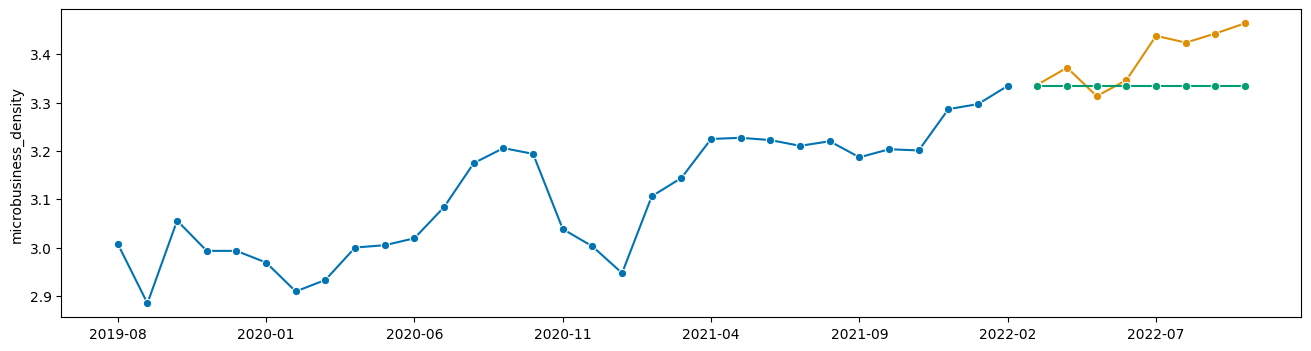

In [73]:
plot_series(y_train, y_test, y_pred)
plt.show()

In [74]:
y = train.loc[train.cfips == 1001]['microbusiness_density']
y_mean = y.copy().mean()
y_std = y.copy().std()

# transformers
transformer1 = Detrender()
transformer2 = Deseasonalizer(sp=12)

# y = np.log1p(y)
y = transformer1.fit_transform(y)
y = transformer2.fit_transform(y)
y = (y - y_mean)/y_std

y_train, y_test = temporal_train_test_split(y, test_size=8)

forecaster = AutoARIMA(
    sp=12, max_p=24, max_d=6, max_q=24, 
    maxiter=5000,
    suppress_warnings=True)  
forecaster.fit(y_train)  

y_pred = forecaster.predict(fh=y_test.index) 

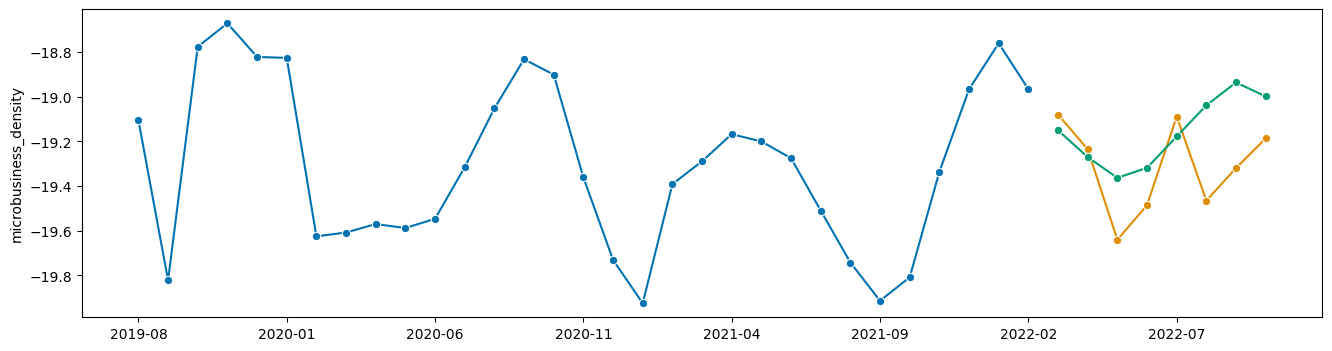

In [75]:
plot_series(y_train, y_test, y_pred)
plt.show()

In [76]:
y_pred_inverse = y_pred * y_std + y_mean
y_pred_inverse = transformer2.inverse_transform(y_pred_inverse)
y_pred_inverse = transformer1.inverse_transform(y_pred_inverse)

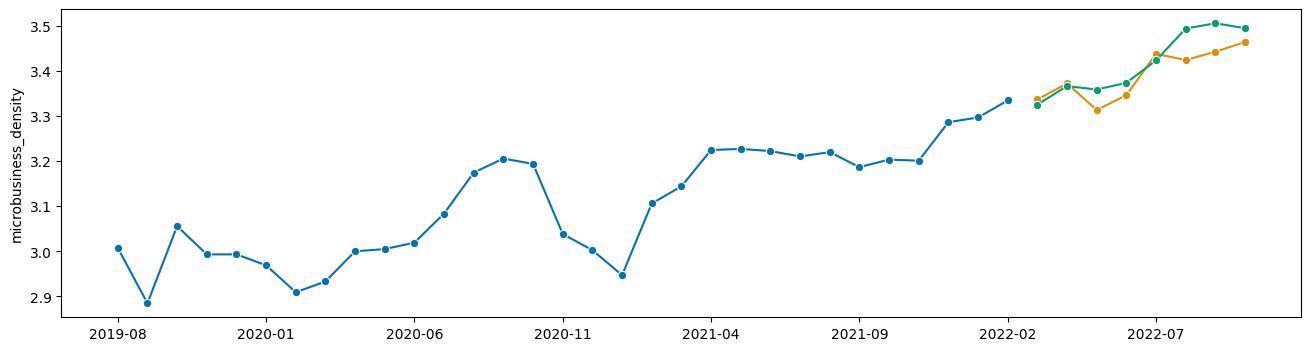

In [77]:
y = train.loc[train.cfips == 1001]['microbusiness_density']

y_train, y_test = temporal_train_test_split(y, test_size=8)

plot_series(y_train, y_test, y_pred_inverse)
plt.show()

In [78]:
# métrica
def smape(a, b):
    a = np.array(a).flatten()
    b = np.array(b).flatten()
    both = np.abs(a) + np.abs(b)
    idx = np.where(both==0)[0]
    a[idx]=1; b[idx]=1
    return 1/len(a) * np.sum(2*np.abs(b-a)/(np.abs(a)+np.abs(b))*100)

smape(y_test, y_pred_inverse)

0.980672763879708

In [79]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   31
Model:             SARIMAX(0, 0, 2)x(1, 0, [], 12)   Log Likelihood                  -0.723
Date:                             Wed, 05 Jul 2023   AIC                             11.445
Time:                                     08:26:19   BIC                             18.615
Sample:                                 08-31-2019   HQIC                            13.782
                                      - 02-28-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -30.8616      3.116     -9.904      0.000     -36.969     -24.754
ma.L1          0.3730      0.136      2.751      0.006       0.107       0.639
ma.L2          0.8523      0.190      4.494      0.000       0.481       1.224
ar.S.L12      -0.5989      0.162     -3.702      0.000      -0.916      -0.282
sigma2         0.0486      0.015      3.149      0.002       0.018       0.079
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                 1.02
Prob(Q):                              0.49   Prob(JB):                         0.60
Heteroskedasticity (H):               0.24   Skew:                             0.44
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
explained_variance_score(y_test, y_pred_inverse)

0.6560492862739284

In [81]:
mean_absolute_error(y_test, y_pred_inverse)

0.033577153737353094

- https://towardsdatascience.com/choosing-the-correct-error-metric-mape-vs-smape-5328dec53fac

In [82]:
y = train.loc[train.cfips == 1005]['microbusiness_density']
y_mean = y.copy().mean()
y_std = y.copy().std()

# transformers
transformer1 = Detrender()
transformer2 = Deseasonalizer(sp=12)

# y = np.log1p(y)
y = transformer1.fit_transform(y)
y = transformer2.fit_transform(y)
y = (y - y_mean)/y_std

forecaster = AutoARIMA(
    sp=12, max_p=24, max_d=6, max_q=24, 
    maxiter=5000,
    suppress_warnings=True)  
forecaster.fit(y)  

y_pred = forecaster.predict(fh=np.arange(1,9)) 

y_pred_inverse = y_pred * y_std + y_mean
y_pred_inverse = transformer2.inverse_transform(y_pred_inverse)
y_pred_inverse = transformer1.inverse_transform(y_pred_inverse)

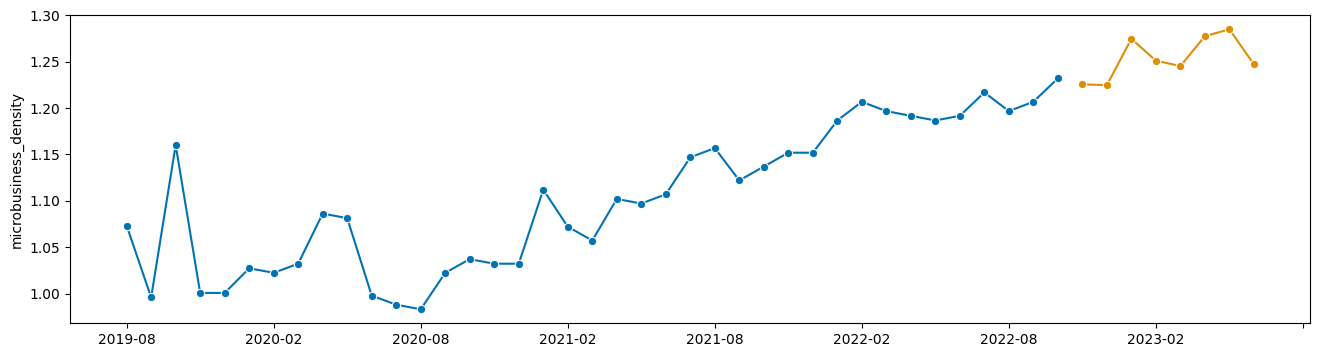

In [83]:
plot_series(train.loc[train.cfips == 1005]['microbusiness_density'], y_pred_inverse)
plt.show()

## Usando variável exôgenea

In [84]:
y = train.loc[train.cfips == 1001]['microbusiness_density']
X = train.loc[train.cfips == 1001][['active']]
y_mean = y.copy().mean()
y_std = y.copy().std()

# transformers
transformer1 = Detrender()
transformer2 = Deseasonalizer(sp=12)

# y = np.log1p(y)
y = transformer1.fit_transform(y)
y = transformer2.fit_transform(y)
y = (y - y_mean)/y_std

# forescat horizon
fh = ForecastingHorizon(
    pd.PeriodIndex(
        pd.date_range('2022-03', periods=8, freq="M")
    ),
    is_relative=False)

# train test split
y_train, y_test, X_train, X_test = temporal_train_test_split(
    y, X, fh=fh
)

forecaster = AutoARIMA(
    sp=12, max_p=24, max_d=6, max_q=24, 
    maxiter=5000,
    suppress_warnings=True)  
forecaster.fit(y_train, X_train)  

y_pred = forecaster.predict(fh, X=X_test) 

C:\Users\leandro\Downloads\cd2023\cd2023\env\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(1,0,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


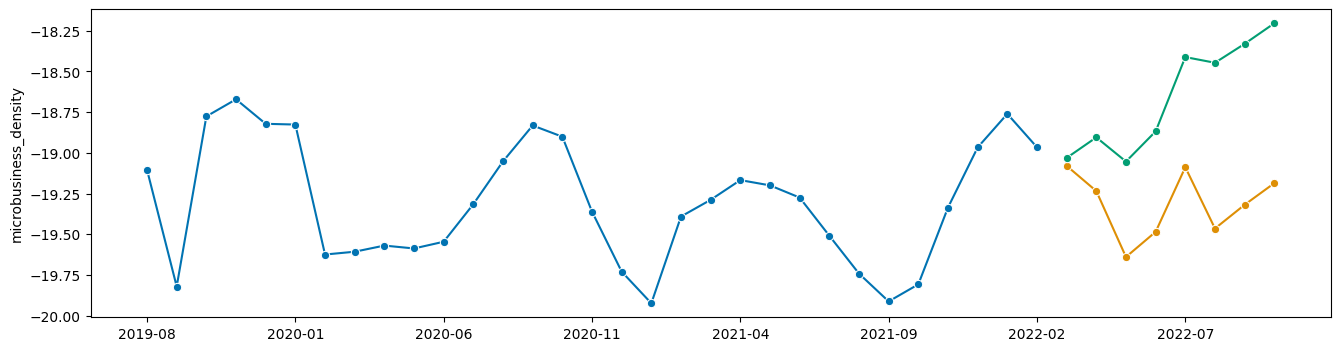

In [85]:
plot_series(y_train, y_test, y_pred)
plt.show()

## Regressão com Sktime

In [86]:
# get model
regressor = GradientBoostingRegressor()

# convert data to tabular and ajust model
forecaster = make_reduction(
    regressor, 
    window_length=10, 
    strategy="recursive")

# fit model
forecaster.fit(y_train, X_train)

# get predictions
y_pred = forecaster.predict(fh, X=X_test)

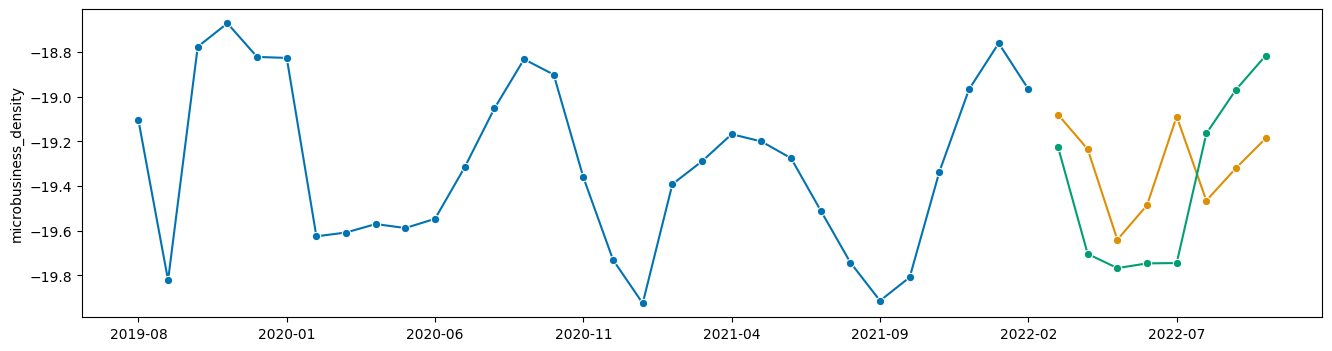

In [87]:
plot_series(y_train, y_test, y_pred)
plt.show()

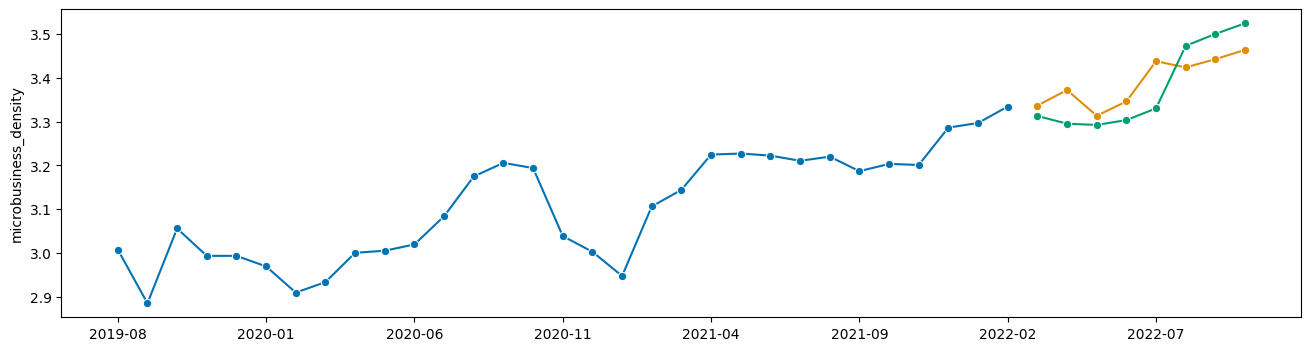

In [88]:
y_pred_inverse = y_pred * y_std + y_mean
y_pred_inverse = transformer2.inverse_transform(y_pred_inverse)
y_pred_inverse = transformer1.inverse_transform(y_pred_inverse)
y = train.loc[train.cfips == 1001]['microbusiness_density']

y_train, y_test = temporal_train_test_split(y, test_size=8)

plot_series(y_train, y_test, y_pred_inverse)
plt.show()

In [89]:
explained_variance_score(y_test, y_pred_inverse)

-0.2581910424288345

In [90]:
smape(y_test, y_pred_inverse)

1.6195510577521652

In [91]:
mean_absolute_error(y_test, y_pred_inverse)

0.054985272167749066

## Exercício

Faça uma submissão no desafio https://www.kaggle.com/competitions/store-sales-time-series-forecasting

<b>Referências</b>

- https://towardsdatascience.com/7-statistical-tests-to-validate-and-help-to-fit-arima-model-33c5853e2e93
- https://www.kaggle.com/code/poojapb2002/time-series-using-arima-for-beginners#AutoCorrelation-graph